Code to test the precision of the end point with dmp and cvae

In [1]:
import os, time, tqdm, sys
import torch.nn as nn
import numpy as np
import torch

# add parent dictionary to path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)

from models.vae import TrajGen, DM
from models.dmp import CanonicalSystem, SingleDMP
from utils.data_loader import TorqueLoader as Torque_dataset
from utils.early_stop import EarlyStop
from matplotlib import pyplot as plt
from collections import OrderedDict
print(os.getcwd())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/home/binzhao/Documents/code/VAE_DMP_mani/number_write_task


In [2]:
# load the data set and the class to normalize the data
# denormalize the torque0.0012    & 0.0116 
run_time = 1
dt = 0.01
shape = (2, 100)
# create dataset for training and testing
cs = CanonicalSystem(dt=0.01, ax=1)
dmp = SingleDMP(n_bfs=50, cs=cs, run_time=1.0, dt=0.01)


train_dataset = Torque_dataset(run_time=1, dmp=dmp, dt=0.01, dof=2)
train_dataset.load_data('../data/number_write/train_torque.npz', device=device)
train_dataset.torque = train_dataset.normalize_data(device=device)

#get normalize  paramters of data
max = train_dataset.max.cpu().numpy()
min = train_dataset.min.cpu().numpy()
print(max, min)

[178.56984 199.07835] [-187.85435 -179.23535]


load the pretrain torque based trajectory generator (cVAE based)

In [3]:
# load the pretrained model
save_name = "cVAE_torque.pt"
checkpoint = torch.load(save_name, map_location=device)
dict = checkpoint['net']

/tmp/ipykernel_300016/1858532253.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(save_name, map_location=device)


In [4]:
# load the decoder part only -- generator
decoder_param = OrderedDict() 
    
key_word_1 = {"decoder."}
key_word_2 = {"label_embedding."}

for layer_name, param in checkpoint["net"].items():
    for key_word in key_word_1:
        if key_word in layer_name:            
            layer_name = layer_name.replace(key_word, "")            
            decoder_param[layer_name] = param

torch.save(decoder_param, "../models/decoder.pt")

# save label encoder
label_encoder_param = OrderedDict()
for layer_name, param in checkpoint["net"].items():
    for key_word in key_word_2:
        if key_word in layer_name:            
            layer_name = layer_name.replace(key_word, "")            
            label_encoder_param[layer_name] = param

torch.save(label_encoder_param, "../models/label_encoder.pt")

create trajecotr generator  --  decoder + dynamics systems

In [5]:
shape = (2, 100)
nclass=10
nhid=8
ncond=8
traj_gen = TrajGen(shape=shape, nclass=nclass, nhid=nhid, ncond=ncond, min=min, max=max, device=device)
# send to device
traj_gen = traj_gen.to(device)
# load model
traj_gen.decoder_o.load_state_dict(torch.load('../models/decoder.pt'))
traj_gen.decoder_n.load_state_dict(torch.load('../models/decoder.pt'))
traj_gen.label_embedding.load_state_dict(torch.load('../models/label_encoder.pt'))

/tmp/ipykernel_300016/2391882050.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  traj_gen.decoder_o.load_state_dict(torch.load('../models/decoder.pt'))
/tmp/ipykernel_30

<All keys matched successfully>

In [6]:
# create a data set for the cVAE testing
start = np.array([0, 1])
ends = np.array([1, 0])
end_range = 0.3
end_offset = 0

numbers = [1, 2, 3, 6, 7]
aug_number = 200
train_dataset = []
train_labels = []

# generate the data set
for number in numbers:
    for i in range(aug_number):
        end = ends + end_range * (np.random.rand(2) - 0.5) + end_offset

        traj_gen.eval()
        with torch.no_grad():
            data = traj_gen(number, x0=start, goal=end)
        traj = data.detach().cpu().numpy()[0, :, :]        
        labels = np.concatenate((np.array([number]), traj[:,0], traj[:, -1]))
        train_dataset.append(traj)
        train_labels.append(labels)     

1000


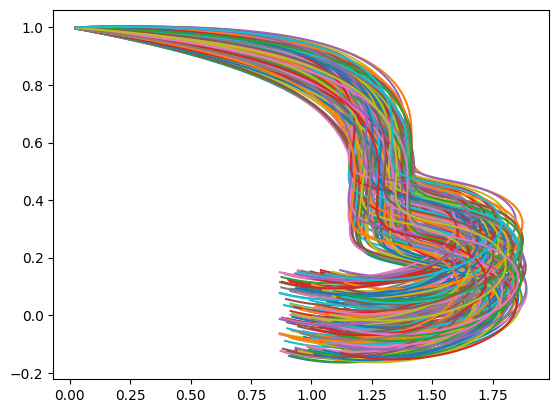

In [7]:
print(len(train_dataset))
# plot the data in the train_dataset
plt.figure()
for traj, labels in zip(train_dataset, train_labels):    
    if labels[0] == 3:
        plt.plot(traj[0, :], traj[1, :])

file_name = f"test_traj_{aug_number}.npz"
# save the data set
np.savez("../data/number_write/cVAE_dataset/" + file_name, train_dataset=train_dataset, labels=train_labels)

In [8]:
train_data = np.load("../data/number_write/cVAE_dataset/" + file_name)
print(train_data['train_dataset'].shape)
print(train_data['labels'].shape)

(1000, 2, 100)
(1000, 5)


In [9]:
# a data loader for the cVAE
import torch
from torch.utils.data import Dataset, DataLoader

class cVAE_loader(Dataset):
    def __init__(self, file_name, device):
        data = np.load(file_name)
        self.data = data['train_dataset']        
        self.labels = data['labels']
        self.device = device

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        traj = self.data[idx]
        traj = torch.tensor(traj, dtype=torch.float32).to(self.device)
        label = self.labels[idx]
        label = torch.tensor(label, dtype=torch.float32).to(self.device)
        return traj, label

In [10]:
# train the cVAE model
train_dataset = cVAE_loader("../data/number_write/cVAE_dataset/"+file_name, device=device)
train_iter = DataLoader(train_dataset, batch_size=64, shuffle=True)
# check the data
for traj, label in train_iter:
    print(f"Trajectory shape: {traj.shape}")  # Expected: (batch_size, feature_dim)
    print(f"Label shape: {label.shape}")  # Expected: (batch_size,)
    break  # Stop after first batch

Trajectory shape: torch.Size([64, 2, 100])
Label shape: torch.Size([64, 5])


In [11]:
# the 1D cVAE model
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        batch_size = x.shape[0]
        return x.view(batch_size, -1)


class MLP(nn.Module):
    def __init__(self, hidden_size, last_activation=True):
        super(MLP, self).__init__()
        q = []
        for i in range(len(hidden_size)-1):
            in_dim = hidden_size[i]
            out_dim = hidden_size[i+1]
            q.append(("Linear_%d" % i, nn.Linear(in_dim, out_dim)))
            if (i < len(hidden_size)-2) or ((i == len(hidden_size) - 2) and (last_activation)):
                # q.append(("BatchNorm_%d" % i, nn.BatchNorm1d(out_dim)))
                q.append(("ReLU_%d" % i, nn.ReLU(inplace=True)))
        self.mlp = nn.Sequential(OrderedDict(q))

    def forward(self, x):
        return self.mlp(x)


class Encoder(nn.Module):
    def __init__(self, shape, nhid=4, ncond=0):
        """
        the shape of input data -- (ndof, time_steps)
        """
        super(Encoder, self).__init__()
        self.n_dof, self.time_steps = shape
        # calculate the shape of the output of the encoder
        ww = ((self.time_steps - 5) // 2 + 1)
        ww = ((ww - 5) // 2 + 1) // 2
        ww = ((ww - 3) // 2 + 1)
        ww = ((ww - 3) // 2 + 1) // 2

        self.encode = nn.Sequential(nn.Conv1d(self.n_dof, 16, 5, stride=2, padding=0), nn.BatchNorm1d(16), nn.ReLU(inplace=True),
                                    nn.Conv1d(16, 32, 5, stride=2, padding=0), nn.BatchNorm1d(32), nn.ReLU(inplace=True),
                                    nn.MaxPool1d(2),
                                    nn.Conv1d(32, 64, 3, stride=2, padding=0), nn.BatchNorm1d(64), nn.ReLU(inplace=True),
                                    nn.Conv1d(64, 64, 3, stride=2, padding=0), nn.BatchNorm1d(64), nn.ReLU(inplace=True),
                                    nn.MaxPool1d(2),
                                    Flatten(), MLP([ww*64, self.n_dof*32]))

        self.calc_mean = MLP([32*self.n_dof+ncond, 16*self.n_dof+ncond, 16*self.n_dof, nhid*self.n_dof], last_activation=False)
        self.calc_logvar = MLP([32*self.n_dof+ncond, 16*self.n_dof+ncond, 16*self.n_dof, nhid*self.n_dof], last_activation=False)

    def forward(self, x, y=None):
        """
        :param x: (batch_size, n_dof, time_steps)
        :param y: (batch_size, ncond)  -- condition 
        """
        x = self.encode(x)
        if (y is None):
            return self.calc_mean(x), self.calc_logvar(x)
        else:
            mean = self.calc_mean(torch.cat((x, y), dim=1))
            logvar = self.calc_logvar(torch.cat((x, y), dim=1))

        return mean, logvar


class Decoder(nn.Module):
    def __init__(self, shape, nhid=8, ncond=0):
        super(Decoder, self).__init__()
        self.n_dof, self.time_steps = shape
        self.shape = shape
        self.decode = nn.Sequential(MLP([nhid*self.n_dof+ncond, 64, 128, self.time_steps*self.n_dof],
                                        last_activation=False), nn.Sigmoid())

    def forward(self, z, y=None):
        c, w = self.shape
        if (y is None):
            return self.decode(z).view(-1, c, w)
        else:
            return self.decode(torch.cat((z, y), dim=1)).view(-1, c, w)


class CVAE(nn.Module):
    def __init__(self, shape, nclass, npos, nhid=8, ncond=4):
        """
        :param shape: the shape of the input data
        :param nclass: the number of classes
        :param condition: the number of condition: end position
        """
        super(CVAE, self).__init__()
        self.n_dof, self.time_steps = shape
        self.dim = self.n_dof * nhid
        self.encoder = Encoder(shape, nhid, ncond+npos)
        self.decoder = Decoder(shape, nhid, ncond + npos)
        
        self.label_embedding = nn.Embedding(nclass, ncond)  
        self.mse_loss = nn.MSELoss()

    def forward(self, x, y=None):
        if (y is not None):
            label = y[:, 0].to(dtype=torch.int)
            position = y[:, 1:]
            label_emb = self.label_embedding(label)
            em_condit = torch.cat([label_emb, position], dim=1)
        else:
            em_condit = None

        mean, logvar = self.encoder(x, em_condit)
        z = self.reparameterize(mean, logvar)
        x_hat = self.decoder(z, em_condit)
        return x_hat, mean, logvar

    def reparameterize(self, mean, logvar):
        eps = torch.randn(mean.shape).to(device)
        sigma = 0.5 * torch.exp(logvar)
        return mean + eps * sigma

    def loss(self, X, X_hat, mean, logvar):
        reconstruction_loss = self.mse_loss(X_hat, X)
        KL_divergence = 0.5 * torch.sum(-1 - logvar + torch.exp(logvar) + mean**2)
        return reconstruction_loss + KL_divergence

    def generate(self, condition):
        if (type(condition) is not torch.Tensor):
            condition = torch.tensor(condition)
        class_idx = class_idx.to(device)
        if (len(condition.shape) == 0):
            batch_size = None
            class_idx = class_idx.unsqueeze(0)
            z = torch.randn((1, self.dim)).to(device)
        else:
            batch_size = class_idx.shape[0]
            z = torch.randn((batch_size, self.dim)).to(device)

        label = condition[:, 0].to(dtype=torch.int)
        position = condition[:, 1:]
        label_emb = self.label_embedding(label)
        em_condit = torch.cat([label_emb, position], dim=1)
        res = self.decoder(z, em_condit)     
        
        return res

load the data set

In [12]:
# create the cVAE model
cvae_net = CVAE(shape=shape, nclass=10, npos=4, nhid=8, ncond=8)
cvae_net = cvae_net.to(device)

In [13]:
#train model
lr = 1e-4
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, cvae_net.parameters()), lr=lr, weight_decay=0.0001)

def adjust_lr(optimizer, decay_rate=0.95):
    for param_group in optimizer.param_groups:
        param_group['lr'] *= decay_rate

#if load
save_name = "cVAE_basic.pt"
retrain = True
if os.path.exists(save_name):
    print("Model parameters have already been trained before. Retrain ? (y/n)")
    ans = input()
    if not (ans == 'y'):
        checkpoint = torch.load(save_name, map_location=device)
        cvae_net.load_state_dict(checkpoint["net"])
        optimizer.load_state_dict(checkpoint["optimizer"])
        for g in optimizer.param_groups:
            g['lr'] = lr

max_epochs = 100
early_stop = EarlyStop(patience=10, save_name=save_name)

Training the network

In [14]:
print("training on ", device)
for epoch in range(max_epochs):
    cvae_net.train()
    train_loss, n, start = 0.0, 0, time.time()
    for X, y in tqdm.tqdm(train_iter, ncols=50):
        X = X.to(device)
        y = y.to(device)       
        X_hat, mean, logvar = cvae_net(X, y)

        l = cvae_net.loss(X, X_hat, mean, logvar).to(device)
        optimizer.zero_grad()
        l.backward()
        optimizer.step()

        train_loss += l.cpu().item()
        n += X.shape[0]

    train_loss /= n
    print('epoch %d, train loss %.4f , time %.1f sec'
          % (epoch, train_loss, time.time() - start))

    adjust_lr(optimizer)

training on  cuda


100%|█████████████| 16/16 [00:00<00:00, 64.18it/s]


epoch 0, train loss 0.1982 , time 0.3 sec


100%|████████████| 16/16 [00:00<00:00, 354.10it/s]


epoch 1, train loss 0.1392 , time 0.0 sec


100%|████████████| 16/16 [00:00<00:00, 228.00it/s]


epoch 2, train loss 0.1055 , time 0.1 sec


100%|████████████| 16/16 [00:00<00:00, 345.08it/s]


epoch 3, train loss 0.0837 , time 0.0 sec


100%|████████████| 16/16 [00:00<00:00, 335.29it/s]


epoch 4, train loss 0.0686 , time 0.0 sec


100%|████████████| 16/16 [00:00<00:00, 346.41it/s]


epoch 5, train loss 0.0568 , time 0.0 sec


100%|████████████| 16/16 [00:00<00:00, 349.15it/s]


epoch 6, train loss 0.0471 , time 0.0 sec


100%|████████████| 16/16 [00:00<00:00, 348.17it/s]


epoch 7, train loss 0.0387 , time 0.0 sec


100%|████████████| 16/16 [00:00<00:00, 343.06it/s]


epoch 8, train loss 0.0318 , time 0.0 sec


100%|████████████| 16/16 [00:00<00:00, 345.93it/s]


epoch 9, train loss 0.0260 , time 0.0 sec


100%|████████████| 16/16 [00:00<00:00, 344.81it/s]


epoch 10, train loss 0.0211 , time 0.0 sec


100%|████████████| 16/16 [00:00<00:00, 351.96it/s]


epoch 11, train loss 0.0174 , time 0.0 sec


100%|████████████| 16/16 [00:00<00:00, 338.05it/s]


epoch 12, train loss 0.0147 , time 0.0 sec


100%|████████████| 16/16 [00:00<00:00, 352.43it/s]


epoch 13, train loss 0.0127 , time 0.0 sec


100%|████████████| 16/16 [00:00<00:00, 362.56it/s]


epoch 14, train loss 0.0109 , time 0.0 sec


100%|████████████| 16/16 [00:00<00:00, 336.71it/s]


epoch 15, train loss 0.0095 , time 0.0 sec


100%|████████████| 16/16 [00:00<00:00, 319.51it/s]


epoch 16, train loss 0.0085 , time 0.1 sec


100%|████████████| 16/16 [00:00<00:00, 332.08it/s]


epoch 17, train loss 0.0075 , time 0.0 sec


100%|████████████| 16/16 [00:00<00:00, 355.37it/s]


epoch 18, train loss 0.0067 , time 0.0 sec


100%|████████████| 16/16 [00:00<00:00, 351.70it/s]


epoch 19, train loss 0.0061 , time 0.0 sec


100%|████████████| 16/16 [00:00<00:00, 305.88it/s]


epoch 20, train loss 0.0057 , time 0.1 sec


100%|████████████| 16/16 [00:00<00:00, 313.61it/s]


epoch 21, train loss 0.0052 , time 0.1 sec


100%|████████████| 16/16 [00:00<00:00, 347.42it/s]


epoch 22, train loss 0.0049 , time 0.0 sec


100%|████████████| 16/16 [00:00<00:00, 348.77it/s]


epoch 23, train loss 0.0045 , time 0.0 sec


100%|████████████| 16/16 [00:00<00:00, 345.24it/s]


epoch 24, train loss 0.0043 , time 0.0 sec


100%|████████████| 16/16 [00:00<00:00, 348.03it/s]


epoch 25, train loss 0.0041 , time 0.0 sec


100%|████████████| 16/16 [00:00<00:00, 343.21it/s]


epoch 26, train loss 0.0040 , time 0.0 sec


100%|████████████| 16/16 [00:00<00:00, 298.53it/s]


epoch 27, train loss 0.0038 , time 0.1 sec


100%|████████████| 16/16 [00:00<00:00, 353.78it/s]


epoch 28, train loss 0.0036 , time 0.0 sec


100%|████████████| 16/16 [00:00<00:00, 348.13it/s]


epoch 29, train loss 0.0035 , time 0.0 sec


100%|████████████| 16/16 [00:00<00:00, 350.01it/s]


epoch 30, train loss 0.0035 , time 0.0 sec


100%|████████████| 16/16 [00:00<00:00, 347.50it/s]


epoch 31, train loss 0.0034 , time 0.0 sec


100%|████████████| 16/16 [00:00<00:00, 347.03it/s]


epoch 32, train loss 0.0033 , time 0.0 sec


100%|████████████| 16/16 [00:00<00:00, 345.83it/s]


epoch 33, train loss 0.0032 , time 0.0 sec


100%|████████████| 16/16 [00:00<00:00, 344.39it/s]


epoch 34, train loss 0.0032 , time 0.0 sec


100%|████████████| 16/16 [00:00<00:00, 345.64it/s]


epoch 35, train loss 0.0031 , time 0.0 sec


100%|████████████| 16/16 [00:00<00:00, 348.61it/s]


epoch 36, train loss 0.0031 , time 0.0 sec


100%|████████████| 16/16 [00:00<00:00, 342.07it/s]


epoch 37, train loss 0.0030 , time 0.0 sec


100%|████████████| 16/16 [00:00<00:00, 333.84it/s]


epoch 38, train loss 0.0030 , time 0.0 sec


100%|████████████| 16/16 [00:00<00:00, 342.69it/s]


epoch 39, train loss 0.0030 , time 0.0 sec


100%|████████████| 16/16 [00:00<00:00, 303.60it/s]


epoch 40, train loss 0.0029 , time 0.1 sec


100%|████████████| 16/16 [00:00<00:00, 342.08it/s]


epoch 41, train loss 0.0029 , time 0.0 sec


100%|████████████| 16/16 [00:00<00:00, 345.27it/s]


epoch 42, train loss 0.0029 , time 0.0 sec


100%|████████████| 16/16 [00:00<00:00, 348.28it/s]


epoch 43, train loss 0.0028 , time 0.0 sec


100%|████████████| 16/16 [00:00<00:00, 345.29it/s]


epoch 44, train loss 0.0028 , time 0.0 sec


100%|████████████| 16/16 [00:00<00:00, 339.27it/s]


epoch 45, train loss 0.0027 , time 0.0 sec


100%|████████████| 16/16 [00:00<00:00, 347.82it/s]


epoch 46, train loss 0.0026 , time 0.0 sec


100%|████████████| 16/16 [00:00<00:00, 349.73it/s]


epoch 47, train loss 0.0027 , time 0.0 sec


100%|████████████| 16/16 [00:00<00:00, 337.47it/s]


epoch 48, train loss 0.0027 , time 0.0 sec


100%|████████████| 16/16 [00:00<00:00, 333.14it/s]


epoch 49, train loss 0.0027 , time 0.0 sec


100%|████████████| 16/16 [00:00<00:00, 343.46it/s]


epoch 50, train loss 0.0026 , time 0.0 sec


100%|████████████| 16/16 [00:00<00:00, 346.13it/s]


epoch 51, train loss 0.0027 , time 0.0 sec


100%|████████████| 16/16 [00:00<00:00, 347.49it/s]


epoch 52, train loss 0.0027 , time 0.0 sec


100%|████████████| 16/16 [00:00<00:00, 297.37it/s]


epoch 53, train loss 0.0027 , time 0.1 sec


100%|████████████| 16/16 [00:00<00:00, 338.95it/s]


epoch 54, train loss 0.0025 , time 0.0 sec


100%|████████████| 16/16 [00:00<00:00, 348.11it/s]


epoch 55, train loss 0.0026 , time 0.0 sec


100%|████████████| 16/16 [00:00<00:00, 344.26it/s]


epoch 56, train loss 0.0026 , time 0.0 sec


100%|████████████| 16/16 [00:00<00:00, 348.51it/s]


epoch 57, train loss 0.0026 , time 0.0 sec


100%|████████████| 16/16 [00:00<00:00, 307.90it/s]


epoch 58, train loss 0.0026 , time 0.1 sec


100%|████████████| 16/16 [00:00<00:00, 325.87it/s]


epoch 59, train loss 0.0025 , time 0.1 sec


100%|████████████| 16/16 [00:00<00:00, 328.56it/s]


epoch 60, train loss 0.0026 , time 0.0 sec


100%|████████████| 16/16 [00:00<00:00, 328.89it/s]


epoch 61, train loss 0.0025 , time 0.0 sec


100%|████████████| 16/16 [00:00<00:00, 340.39it/s]


epoch 62, train loss 0.0025 , time 0.0 sec


100%|████████████| 16/16 [00:00<00:00, 353.44it/s]


epoch 63, train loss 0.0026 , time 0.0 sec


100%|████████████| 16/16 [00:00<00:00, 327.27it/s]


epoch 64, train loss 0.0025 , time 0.0 sec


100%|████████████| 16/16 [00:00<00:00, 341.77it/s]


epoch 65, train loss 0.0025 , time 0.0 sec


100%|████████████| 16/16 [00:00<00:00, 300.45it/s]


epoch 66, train loss 0.0025 , time 0.1 sec


100%|████████████| 16/16 [00:00<00:00, 339.48it/s]


epoch 67, train loss 0.0025 , time 0.0 sec


100%|████████████| 16/16 [00:00<00:00, 336.87it/s]


epoch 68, train loss 0.0025 , time 0.0 sec


100%|████████████| 16/16 [00:00<00:00, 350.31it/s]


epoch 69, train loss 0.0026 , time 0.0 sec


100%|████████████| 16/16 [00:00<00:00, 343.77it/s]


epoch 70, train loss 0.0025 , time 0.0 sec


100%|████████████| 16/16 [00:00<00:00, 332.35it/s]


epoch 71, train loss 0.0025 , time 0.0 sec


100%|████████████| 16/16 [00:00<00:00, 343.61it/s]


epoch 72, train loss 0.0026 , time 0.0 sec


100%|████████████| 16/16 [00:00<00:00, 347.52it/s]


epoch 73, train loss 0.0024 , time 0.0 sec


100%|████████████| 16/16 [00:00<00:00, 333.83it/s]


epoch 74, train loss 0.0025 , time 0.0 sec


100%|████████████| 16/16 [00:00<00:00, 340.14it/s]


epoch 75, train loss 0.0024 , time 0.0 sec


100%|████████████| 16/16 [00:00<00:00, 340.69it/s]


epoch 76, train loss 0.0025 , time 0.0 sec


100%|████████████| 16/16 [00:00<00:00, 345.72it/s]


epoch 77, train loss 0.0025 , time 0.0 sec


100%|████████████| 16/16 [00:00<00:00, 323.13it/s]


epoch 78, train loss 0.0025 , time 0.1 sec


100%|████████████| 16/16 [00:00<00:00, 350.52it/s]


epoch 79, train loss 0.0024 , time 0.0 sec


100%|████████████| 16/16 [00:00<00:00, 345.82it/s]


epoch 80, train loss 0.0024 , time 0.0 sec


100%|████████████| 16/16 [00:00<00:00, 347.61it/s]


epoch 81, train loss 0.0024 , time 0.0 sec


100%|████████████| 16/16 [00:00<00:00, 346.83it/s]


epoch 82, train loss 0.0025 , time 0.0 sec


100%|████████████| 16/16 [00:00<00:00, 344.20it/s]


epoch 83, train loss 0.0024 , time 0.0 sec


100%|████████████| 16/16 [00:00<00:00, 345.66it/s]


epoch 84, train loss 0.0024 , time 0.0 sec


100%|████████████| 16/16 [00:00<00:00, 346.36it/s]


epoch 85, train loss 0.0024 , time 0.0 sec


100%|████████████| 16/16 [00:00<00:00, 343.90it/s]


epoch 86, train loss 0.0024 , time 0.0 sec


100%|████████████| 16/16 [00:00<00:00, 348.10it/s]


epoch 87, train loss 0.0025 , time 0.0 sec


100%|████████████| 16/16 [00:00<00:00, 343.91it/s]


epoch 88, train loss 0.0024 , time 0.0 sec


100%|████████████| 16/16 [00:00<00:00, 346.16it/s]


epoch 89, train loss 0.0025 , time 0.0 sec


100%|████████████| 16/16 [00:00<00:00, 305.15it/s]


epoch 90, train loss 0.0024 , time 0.1 sec


100%|████████████| 16/16 [00:00<00:00, 349.75it/s]


epoch 91, train loss 0.0024 , time 0.0 sec


100%|████████████| 16/16 [00:00<00:00, 334.45it/s]


epoch 92, train loss 0.0024 , time 0.0 sec


100%|████████████| 16/16 [00:00<00:00, 338.91it/s]


epoch 93, train loss 0.0024 , time 0.0 sec


100%|████████████| 16/16 [00:00<00:00, 344.85it/s]


epoch 94, train loss 0.0024 , time 0.0 sec


100%|████████████| 16/16 [00:00<00:00, 346.10it/s]


epoch 95, train loss 0.0024 , time 0.0 sec


100%|████████████| 16/16 [00:00<00:00, 346.50it/s]


epoch 96, train loss 0.0023 , time 0.0 sec


100%|████████████| 16/16 [00:00<00:00, 345.23it/s]


epoch 97, train loss 0.0024 , time 0.0 sec


100%|████████████| 16/16 [00:00<00:00, 346.67it/s]


epoch 98, train loss 0.0024 , time 0.0 sec


100%|████████████| 16/16 [00:00<00:00, 345.37it/s]

epoch 99, train loss 0.0024 , time 0.0 sec
